
# Download Dataset from Roboflow
---



In [ ]:
!curl -L "https://universe.roboflow.com/ds/07AvhQUBB9?key=3n9oDWJ3hL" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
# prompt: Move the folders /train, /valid and the files README.dataset.txt and README.roboflow.txt to a folder called FDDB in MyDrive

import os
from google.colab import drive

drive.mount('/content/drive')

# Define the source and destination paths
source_dir = '/content'  # Assuming the files are in the current Colab environment
destination_dir = '/content/drive/MyDrive/FDDB'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Define the files and folders to move
items_to_move = ['/train', '/valid', 'README.dataset.txt', 'README.roboflow.txt']

# Move the items
for item in items_to_move:
    source_path = os.path.join(source_dir, item)
    destination_path = os.path.join(destination_dir, item)

    if os.path.exists(source_path):
        if os.path.isdir(source_path):
          !mv "$source_path" "$destination_dir"
        else:
          !mv "$source_path" "$destination_dir"
    else:
        print(f"Warning: {item} not found in {source_dir}")

## 1. Data Loading Implementation

In [1]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import json
import os
from PIL import Image
import torch

class FDDBDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms

        # Load COCO annotations
        annotation_file = os.path.join(root_dir, '_annotations.coco.json')
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        # Create image id to annotations mapping
        self.image_to_annotations = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.image_to_annotations:
                self.image_to_annotations[img_id] = []
            self.image_to_annotations[img_id].append(ann)

        self.images = self.coco_data['images']

    def __getitem__(self, idx):
        # Get image info
        img_info = self.images[idx]
        img_path = os.path.join(self.root_dir, img_info['file_name'])

        # Load image
        image = Image.open(img_path).convert('RGB')
        original_width, original_height = image.size

        # Get annotations
        img_id = img_info['id']
        boxes = []
        if img_id in self.image_to_annotations:
            for ann in self.image_to_annotations[img_id]:
                # Convert COCO format [x, y, width, height] to [x1, y1, x2, y2]
                x, y, w, h = ann['bbox']
                # Check if w or h is None and handle it
                if w is None or h is None:
                    continue  # Skip this annotation
                boxes.append([x, y, x + w, y + h])

        # Convert to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Resize image to 300x300 and adjust boxes
        new_size = (300, 300)
        image = image.resize(new_size)
        new_width, new_height = new_size

        # Adjust bounding boxes based on the new image size
        scale_x = new_width / original_width
        scale_y = new_height / original_height
        boxes[:, [0, 2]] *= scale_x  # Scale x coordinates
        boxes[:, [1, 3]] *= scale_y  # Scale y coordinates

        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': torch.ones((len(boxes),), dtype=torch.long),  # 1 for face class
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }

        # Apply transforms only to the image
        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.images)

def get_data_loaders(data_path, batch_size=32):
    # Define simple transforms without augmentations that require box changes
    train_transforms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transforms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    full_dataset = FDDBDataset(root_dir=data_path)

    # Split dataset
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size]
    )

    # Apply transforms
    train_dataset.dataset.transforms = train_transforms
    val_dataset.dataset.transforms = val_transforms

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn
    )

    return train_loader, val_loader

def collate_fn(batch):
    """Custom collate function for handling variable size face detections"""
    images = []
    targets = []
    for img, target in batch:
        images.append(img)
        targets.append(target)
    return torch.stack(images, 0), targets


In [2]:
# prompt: Generate a code to test this dataset and dataloader with a path

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
import json
import os
from PIL import Image

# Assuming FDDBDataset, get_data_loaders, and collate_fn are defined as in the provided code

# Specify the path to your dataset
data_path = "/content/drive/MyDrive/FDDB/train"  # Replace with the actual path

# Test the dataset and dataloader
train_loader, val_loader = get_data_loaders(data_path, batch_size=2)  # Use a small batch size for testing

# Iterate through the train_loader
for images, targets in train_loader:
    print("Images shape:", images.shape)  # Print the shape of the image batch
    # Access individual targets
    for i, target in enumerate(targets):
        print(f"Target {i}:")
        print(f"  Boxes: {target['boxes']}")
        print(f"  Labels: {target['labels']}")
        # ... access other target elements ...

    break # Break after the first batch for testing

# Iterate through the val_loader
for images, targets in val_loader:
    print("Images shape:", images.shape) # Print the shape of the image batch
    # Access individual targets
    for i, target in enumerate(targets):
        print(f"Target {i}:")
        print(f"  Boxes: {target['boxes']}")
        print(f"  Labels: {target['labels']}")
        # ... access other target elements ...
    break # Break after the first batch for testing

print("Dataset and dataloader tested successfully!")

Images shape: torch.Size([2, 3, 300, 300])
Target 0:
  Boxes: tensor([[142.9688,  29.2094, 198.3398,  90.0439]])
  Labels: tensor([1])
Target 1:
  Boxes: tensor([[  6.4904,  32.4519,  14.7837,  49.3990],
        [105.2885,   6.4904, 115.3846,  28.1250],
        [142.0673,  11.5385, 149.6394,  28.8462],
        [180.2885,  49.0385, 185.6971,  61.6587],
        [215.6250,  49.0385, 223.1971,  64.5433],
        [168.0289,  72.8365, 170.9135,  77.8846]])
  Labels: tensor([1, 1, 1, 1, 1, 1])
Images shape: torch.Size([2, 3, 300, 300])
Target 0:
  Boxes: tensor([[  8.6538,  88.7019,  76.4423, 160.8173],
        [160.0962,  91.5865, 235.4567, 170.1923],
        [267.5481, 124.0385, 282.6923, 140.6250]])
  Labels: tensor([1, 1, 1])
Target 1:
  Boxes: tensor([[ 40.3846, 151.4423,  57.3317, 188.2212],
        [103.1250, 159.3750, 118.9904, 191.8269],
        [165.1442, 166.5865, 183.1731, 201.5625],
        [204.8077, 142.7885, 220.6731, 183.8942]])
  Labels: tensor([1, 1, 1, 1])
Dataset and data

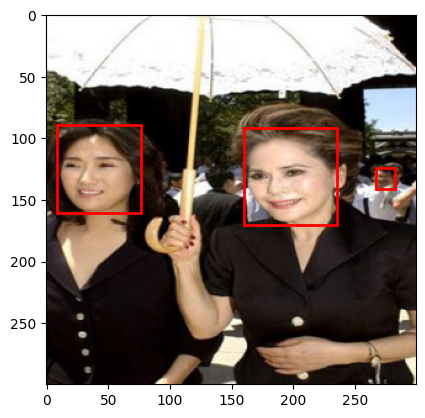

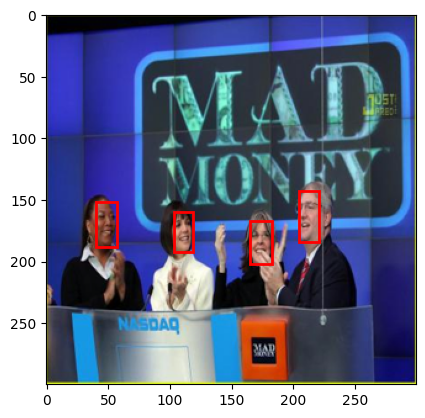

In [3]:
# prompt: Plot an image with the bounding box on it with matplotlib after the transforms are applied and it's resized to 300, 300

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Iterate through the val_loader
for images, targets in val_loader:
    for i, (image, target) in enumerate(zip(images, targets)):
        # Convert image tensor to numpy array and reverse normalization
        image_np = image.permute(1, 2, 0).numpy()
        image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        image_np = (image_np * 255).astype('uint8')

        # Create figure and axes
        fig, ax = plt.subplots(1)

        # Display the image
        ax.imshow(image_np)

        # Draw bounding boxes
        boxes = target['boxes']
        for box in boxes:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), (x2 - x1), (y2 - y1), linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        # Display the plot
        plt.show()

    break # Break after the first batch for testing

# Single Shot Detector

In [8]:
from torchsummary import summary

# Assuming your SSDBase model is defined as in the previous code
model = SSDBase()

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Input size for the summary
input_size = (3, 300, 300)

# Print the model summary
summary(model, input_size=input_size)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,792
              ReLU-2         [-1, 64, 300, 300]               0
            Conv2d-3         [-1, 64, 300, 300]          36,928
              ReLU-4         [-1, 64, 300, 300]               0
         MaxPool2d-5         [-1, 64, 150, 150]               0
            Conv2d-6        [-1, 128, 150, 150]          73,856
              ReLU-7        [-1, 128, 150, 150]               0
            Conv2d-8        [-1, 128, 150, 150]         147,584
              ReLU-9        [-1, 128, 150, 150]               0
        MaxPool2d-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]         295,168
             ReLU-12          [-1, 256, 75, 75]               0
           Conv2d-13          [-1, 256, 75, 75]         590,080
             ReLU-14          [-1, 256,

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models

import torch
import torch.nn as nn
import torchvision.models as models

class SSDBase(nn.Module):
    def __init__(self, pretrained=True):
        super(SSDBase, self).__init__()

        # Load pretrained VGG16
        vgg = models.vgg16(pretrained=pretrained)

        # Extract features up to conv4_3 (23rd layer)
        self.features = nn.Sequential(*list(vgg.features[:22]))

        # Extract layers after conv4_3 up to conv5_3 (30th layer)
        self.extras = nn.Sequential(*list(vgg.features[22:30]))

        # Freeze early layers (optional)
        for i in range(15):  # Freeze up to conv3_3
            for param in self.features[i].parameters():
                param.requires_grad = False

    def forward(self, x):
        conv4_3_feats = self.features(x)  # 38x38
        conv5_feats = self.extras(conv4_3_feats)  # 19x19 (conv7 starts here)
        return conv4_3_feats, conv5_feats


In [5]:
class ExtraFeatureLayers(nn.Module):
    def __init__(self):
        super(ExtraFeatureLayers, self).__init__()
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6),
            nn.ReLU(inplace=True),
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=1),
            nn.ReLU(inplace=True),
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        self.conv9 = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        self.conv10 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
        )

        self.conv11 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        features = []

        # conv6 and conv7 produce the 19x19 feature map
        x = self.conv6(x)
        x = self.conv7(x)
        features.append(x)  # 19x19

        x = self.conv8(x)
        features.append(x)  # 10x10

        x = self.conv9(x)
        features.append(x)  # 5x5

        x = self.conv10(x)
        features.append(x)  # 3x3

        x = self.conv11(x)
        features.append(x)  # 1x1

        return features

In [6]:
class DetectionHeads(nn.Module):
    def __init__(self, num_classes):
        super(DetectionHeads, self).__init__()
        self.num_classes = num_classes
        self.num_default_boxes = [4, 6, 6, 6, 4, 4]  # Default boxes per feature map

        # Update in_channels for the feature maps
        self.in_channels = [512, 1024, 512, 256, 256, 256]  # From conv4_3, conv7, etc.

        # Classification heads
        self.classification_heads = nn.ModuleList([
            nn.Conv2d(in_channels, num_default_boxes * num_classes, kernel_size=3, padding=1)
            for in_channels, num_default_boxes in zip(self.in_channels, self.num_default_boxes)
        ])

        # Regression heads
        self.regression_heads = nn.ModuleList([
            nn.Conv2d(in_channels, num_default_boxes * 4, kernel_size=3, padding=1)
            for in_channels, num_default_boxes in zip(self.in_channels, self.num_default_boxes)
        ])

    def forward(self, features):
        cls_outputs = []
        reg_outputs = []

        for feature, cls_head, reg_head in zip(features, self.classification_heads, self.regression_heads):
            cls_outputs.append(cls_head(feature).permute(0, 2, 3, 1).contiguous())
            reg_outputs.append(reg_head(feature).permute(0, 2, 3, 1).contiguous())

        batch_size = features[0].size(0)
        cls_outputs = torch.cat([output.view(batch_size, -1, self.num_classes) for output in cls_outputs], dim=1)
        reg_outputs = torch.cat([output.view(batch_size, -1, 4) for output in reg_outputs], dim=1)

        return cls_outputs, reg_outputs

In [19]:
import torch
import torch.nn as nn

class SSDModel(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(SSDModel, self).__init__()

        # Initialize base network (VGG16 as the backbone)
        self.base_network = SSDBase(pretrained=pretrained)

        # Extra feature layers
        self.extra_feature_layers = ExtraFeatureLayers()

        # Detection heads (classification and regression)
        self.detection_heads = DetectionHeads(num_classes=num_classes)

    def forward(self, x):
        # Pass input through the base network (VGG16 backbone)
        conv4_3_feats, conv5_feats = base_network(images)

        # Pass through extra feature layers to generate feature maps
        extra_features = extra_features_layers(conv5_feats)

        # Combine the base features with the extra features
        all_features = [conv4_3_feats] + extra_features

        # Pass the feature maps through the detection heads to get
        # classification scores and bounding box predictions
        cls_preds, loc_preds = self.detection_heads(all_features)

        return cls_preds, loc_preds

## Example Usage

In [10]:
# Iterate through the val_loader for testing
base_network = SSDBase()
extra_features_layers = ExtraFeatureLayers()
detection_heads = DetectionHeads(num_classes=2)  # 20 classes + background

for images, targets in val_loader:
    conv4_3_feats, conv5_feats = base_network(images)
    print(f"conv4_3_feats shape: {conv4_3_feats.shape}")  # Should be [batch_size, 512, 38, 38]

    extra_feats = extra_features_layers(conv5_feats)

    # Check all feature maps
    print(f"conv7_feats shape: {conv5_feats.shape}")  # Should be [batch_size, 1024, 19, 19]
    for i, features in enumerate(extra_feats):
        print(f"Extra feature map {i+1} shape: {features.shape}")

    # Send to detection heads
    cls_preds, reg_preds = detection_heads([conv4_3_feats] + extra_feats)
    break


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv4_3_feats shape: torch.Size([2, 512, 37, 37])
conv7_feats shape: torch.Size([2, 512, 18, 18])
Extra feature map 1 shape: torch.Size([2, 1024, 18, 18])
Extra feature map 2 shape: torch.Size([2, 512, 9, 9])
Extra feature map 3 shape: torch.Size([2, 256, 5, 5])
Extra feature map 4 shape: torch.Size([2, 256, 3, 3])
Extra feature map 5 shape: torch.Size([2, 256, 1, 1])


## 4. Default Box Generation:


In [14]:
import numpy as np
class DefaultBoxGenerator:
    def __init__(self):
        self.image_size = 300
        self.feature_maps = [(37, 37), (18, 18), (9, 9), (5, 5), (3, 3), (1, 1)]
        self.steps = [8, 16, 32, 64, 100, 300]
        self.scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
        self.aspect_ratios = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]

    def generate_default_boxes(self):
        default_boxes = []

        for k, fm in enumerate(self.feature_maps):
            for i in range(fm[0]):
                for j in range(fm[1]):
                    cx = (j + 0.5) * self.steps[k] / self.image_size
                    cy = (i + 0.5) * self.steps[k] / self.image_size

                    # Aspect ratio: 1
                    s = self.scales[k]
                    default_boxes.append([cx, cy, s, s])

                    # Aspect ratio: sqrt(s * s_next)
                    if k < len(self.feature_maps) - 1:
                        s_prime = np.sqrt(s * self.scales[k + 1])
                        default_boxes.append([cx, cy, s_prime, s_prime])

                    # Rest of aspect ratios
                    for ar in self.aspect_ratios[k]:
                        default_boxes.extend([
                            [cx, cy, s * np.sqrt(ar), s / np.sqrt(ar)],
                            [cx, cy, s / np.sqrt(ar), s * np.sqrt(ar)]
                        ])

        default_boxes = torch.tensor(default_boxes)
        default_boxes = torch.clamp(default_boxes, 0, 1)
        return default_boxes

## 5. Loss Function Implementation

In [15]:
class SSDLoss(nn.Module):
    def __init__(self):
        super(SSDLoss, self).__init__()
        self.neg_pos_ratio = 3

    def hard_negative_mining(self, cls_loss, pos_mask):
        """Implements hard negative mining to balance positive and negative examples"""
        batch_size = cls_loss.size(0)

        # Calculate number of negative examples to keep
        num_pos = pos_mask.sum(dim=1, keepdim=True)
        num_neg = torch.clamp(self.neg_pos_ratio * num_pos, max=pos_mask.size(1) - 1)

        # Sort negative losses
        cls_loss[pos_mask] = -float('inf')
        _, idx = cls_loss.sort(dim=1, descending=True)
        _, rank = idx.sort(dim=1)

        # Keep top k negative examples
        neg_mask = rank < num_neg

        return neg_mask

    def forward(self, predictions, targets):
        """
        Args:
            predictions: (batch_size, num_priors, num_classes), (batch_size, num_priors, 4)
            targets: (batch_size, num_objects, 5) [class, x, y, w, h]
        """
        cls_preds, loc_preds = predictions
        batch_size = cls_preds.size(0)
        num_priors = cls_preds.size(1)

        # Match priors with ground truth boxes
        pos_mask = torch.zeros(batch_size, num_priors, dtype=torch.bool)
        loc_targets = torch.zeros_like(loc_preds)
        cls_targets = torch.zeros_like(cls_preds)

        for idx in range(batch_size):
            truths = targets[idx][:, 1:]
            labels = targets[idx][:, 0]

            if len(truths) == 0:
                continue

            # Match default boxes to ground truth
            overlaps = self.calculate_iou_matrix(truths, self.default_boxes)
            best_truth_overlap, best_truth_idx = overlaps.max(0)
            best_prior_overlap, best_prior_idx = overlaps.max(1)

            # Set masks and targets
            for prior_idx, truth_idx in enumerate(best_truth_idx):
                if best_truth_overlap[prior_idx] > 0.5:
                    pos_mask[idx, prior_idx] = 1
                    cls_targets[idx, prior_idx] = labels[truth_idx]
                    loc_targets[idx, prior_idx] = self.encode_box(
                        truths[truth_idx], self.default_boxes[prior_idx]
                    )

        # Classification loss
        pos_mask = pos_mask.view(-1)
        cls_loss = F.cross_entropy(
            cls_preds.view(-1, cls_preds.size(-1)),
            cls_targets.view(-1),
            reduction='none'
        )

        # Hard negative mining
        neg_mask = self.hard_negative_mining(cls_loss.view(batch_size, -1), pos_mask.view(batch_size, -1))
        neg_mask = neg_mask.view(-1)

        # Final classification loss
        cls_loss = cls_loss[pos_mask | neg_mask].mean()

        # Localization loss (Smooth L1)
        loc_loss = F.smooth_l1_loss(
            loc_preds[pos_mask],
            loc_targets[pos_mask],
            reduction='sum'
        )
        loc_loss = loc_loss / pos_mask.sum().float()

        return cls_loss + loc_loss

## Non-maximum suppression

In [16]:
def non_maximum_suppression(boxes, scores, iou_threshold=0.5, top_k=200):
    # Sort boxes by score
    _, order = scores.sort(0, descending=True)
    order = order[:top_k]

    kept_boxes = []
    while order.numel() > 0:
        if order.numel() == 1:
            kept_boxes.append(order.item())
            break

        kept_boxes.append(order[0].item())

        # Calculate IoU of the kept box with rest
        ious = calculate_iou_matrix(
            boxes[order[0]].unsqueeze(0),
            boxes[order[1:]]
        )

        # Keep boxes with IoU less than threshold
        mask = ious <= iou_threshold
        order = order[1:][mask]

    return torch.tensor(kept_boxes, dtype=torch.long)

def calculate_iou_matrix(boxes1, boxes2):
    """Calculate IoU between two sets of boxes"""
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    union = area1[:, None] + area2 - inter

    return inter / union

### 2.4 Metrics Implementation


In [7]:
class DetectionMetrics:
    def __init__(self, iou_threshold=0.5):
        self.iou_threshold = iou_threshold

    def calculate_iou(self, box1, box2):
        # Convert to [x1, y1, x2, y2] format
        box1 = torch.cat([box1[:2] - box1[2:]/2, box1[:2] + box1[2:]/2])
        box2 = torch.cat([box2[:2] - box2[2:]/2, box2[:2] + box2[2:]/2])

        # Calculate intersection
        x1 = torch.max(box1[0], box2[0])
        y1 = torch.max(box1[1], box2[1])
        x2 = torch.min(box1[2], box2[2])
        y2 = torch.min(box1[3], box2[3])

        intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

        # Calculate union
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = box1_area + box2_area - intersection

        return intersection / (union + 1e-6)

    def calculate_map(self, predictions, targets):
        precisions = []
        recalls = []

        # Sort predictions by confidence
        conf_sort = torch.argsort(predictions[:, 4], descending=True)
        predictions = predictions[conf_sort]

        # Calculate TP and FP for each confidence threshold
        num_positives = len(targets)
        true_positives = torch.zeros(len(predictions))
        false_positives = torch.zeros(len(predictions))

        for i, pred in enumerate(predictions):
            best_iou = 0
            best_target_idx = -1

            # Find best matching ground truth
            for j, target in enumerate(targets):
                iou = self.calculate_iou(pred[:4], target[:4])
                if iou > best_iou:
                    best_iou = iou
                    best_target_idx = j

            if best_iou > self.iou_threshold:
                true_positives[i] = 1
                targets.pop(best_target_idx)  # Remove matched target
            else:
                false_positives[i] = 1

        # Calculate precision and recall
        cumsum_tp = torch.cumsum(true_positives, dim=0)
        cumsum_fp = torch.cumsum(false_positives, dim=0)

        precisions = cumsum_tp / (cumsum_tp + cumsum_fp + 1e-6)
        recalls = cumsum_tp / num_positives

        # Calculate AP using 11-point interpolation
        ap = 0
        for t in torch.arange(0, 1.1, 0.1):
            if torch.sum(recalls >= t) == 0:
                p = 0
            else:
                p = torch.max(precisions[recalls >= t])
            ap = ap + p / 11.0

        return ap

# Training Loop

In [17]:
def train_ssd(model, train_loader, optimizer, criterion, num_epochs, default_box_generator):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for i, (images, targets) in enumerate(train_loader):
            images = images.cuda()
            # Targets should contain both the bounding boxes and labels, move them to the device
            targets = [target.cuda() for target in targets]

            # Forward pass through the SSD model
            cls_preds, loc_preds = model(images)

            # Generate default boxes for the current batch
            default_boxes = default_box_generator.generate_default_boxes().cuda()

            # Compute the SSD loss (classification + localization)
            loss = criterion((cls_preds, loc_preds), targets, default_boxes)

            # Backward pass (backpropagation)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            if i % 100 == 99:  # Print statistics every 100 mini-batches
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{i+1}/{len(train_loader)}], '
                      f'Loss: {running_loss/100:.4f}')
                running_loss = 0.0

    print('Training completed.')

# Evaluation